<a href="https://colab.research.google.com/github/Pradeepjha88/Cardiac_attack_prediction/blob/master/S013d_data_augmentation_wip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 13d
## Data Augmentation

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [ ]:
# Lets import some libraries
import os

import numpy as np

import cupy as cp

import pandas as pd

import matplotlib.pyplot as plt

from sklearn import datasets

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

In [ ]:
# Some basic parameters

inpDir = '../input' # location where input data is stored
outDir = '../output' # location to store outputs

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
cp.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results

EPOCHS = 20000  # number of cycles to run

ALPHA = 0.1  # learning rate

TEST_SIZE = 0.2 # What fraction we want to keep for testing

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (12,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }
CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Generate Data Set
<div style="font-family: Arial; font-size:1.1em;">
For this exercise, we will be using a iris dataset.
     </div>

In [ ]:
iris = datasets.load_iris()
X = iris.data  # we only take the first two features.
y = iris.target
X.shape, y.shape

((150, 4), (150,))

In [ ]:
cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
data_df = pd.DataFrame(X, columns=cols)
data_df['labels'] = y
data_df.head()

,sepal_length,sepal_width,petal_length,petal_width,labels
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [ ]:
data_df['labels'].unique()

array([0, 1, 2])

In [ ]:
noise = np.random.randn(data_df.shape[0],data_df.shape[1])
noise[:3]

array([[ 0.21449384, -0.10387854,  0.77090015,  0.91315039, -0.24997101],
       [-1.30151086,  2.2982066 , -1.48549736,  0.16788326,  0.08374352],
       [-2.01000451,  1.08255258,  0.37411376, -1.1078289 , -0.76838756]])

In [ ]:
more_data_df = data_df.copy()

for i, col in enumerate(more_data_df.columns[0:4]):
    print ('Processing column :{}'.format(col))
    mult_factor = (more_data_df[col].max() - more_data_df[col].min())/ 50.0 # one fiftieth of the difference
    more_data_df[col] = more_data_df[col] + noise[:, i] * mult_factor

Processing column :sepal_length
Processing column :sepal_width
Processing column :petal_length
Processing column :petal_width


In [ ]:
more_data_df.shape

(150, 5)

## Plotting samples

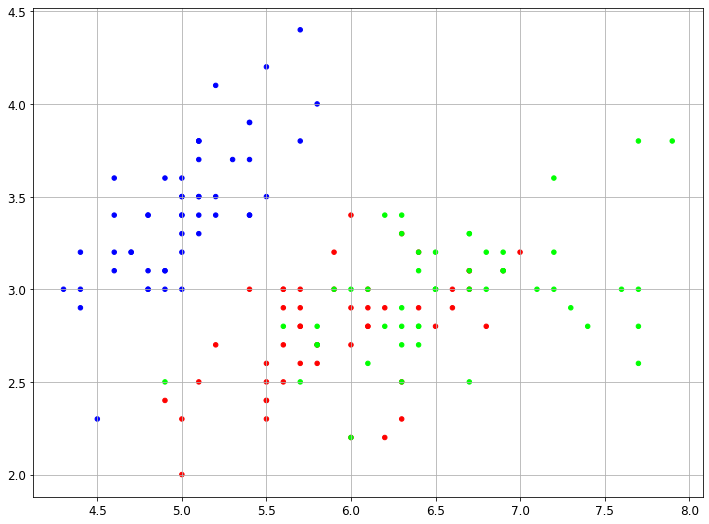

In [ ]:
# Plot the data
plt.scatter(X[:,0], X[:,1], s=20, c=y, cmap=CMAP)

plt.grid()

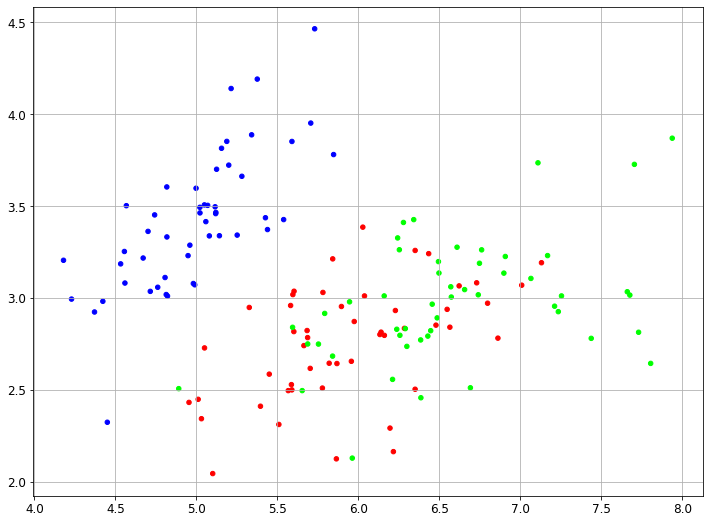

In [ ]:
# Plot the data
plt.scatter(more_data_df['sepal_length'], more_data_df['sepal_width'],
            s=20, c=more_data_df['labels'], cmap=CMAP)

plt.grid()

In [ ]:
aug_data_df = pd.concat([data_df, more_data_df])
aug_data_df.shape

(300, 5)

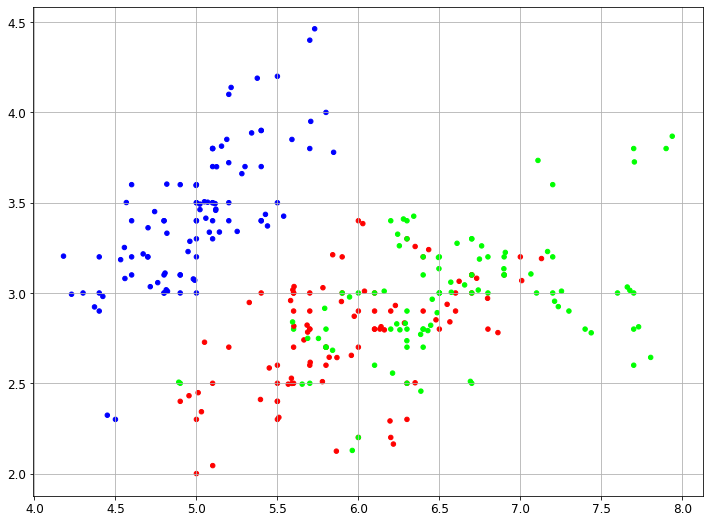

In [ ]:
# Plot the data
# Plot the data
plt.scatter(aug_data_df['sepal_length'], aug_data_df['sepal_width'],
            s=20, c=aug_data_df['labels'], cmap=CMAP)

plt.grid()

In [ ]:
y = aug_data_df['labels'].values
X = aug_data_df.drop('labels', axis=1).values
X.shape, y.shape

((300, 4), (300,))

In [ ]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(240, 4) (240,) (60, 4) (60,)


In [ ]:
one_hot = OneHotEncoder(sparse=False)
y_train = one_hot.fit_transform(y_train.reshape(-1, 1))
y_test = one_hot.transform(y_test.reshape(-1, 1))

In [ ]:
y_train.shape, y_test.shape

((240, 3), (60, 3))

In [ ]:
y_train[:5]

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [ ]:
def fn_softmax(z):
    
    '''
    Args:
        z : a matrix of z values of shape (m, n_output)
    returns:
        Softmax values of z
    
    '''
    exp_scores = np.exp(z - np.max(z)) # to avoid softmax to go exceptionally high

    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    

## Loss Function

In [ ]:
# Helper function to evaluate the total loss on the dataset

def calculate_loss(model, X, y):
    '''
    Args:
        model: dictionay object containing weights and biases
        X: Feature Matrix
        y: Labels array
    Returns:
        Average loss
    '''
    
    # extract weights and losses from the model
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation to calculate our predictions
    # Layer 1
    z1 = X.dot(W1) + b1
    
    # Tanh activation
    a1 = np.tanh(z1)
    
    # Layer 2
    z2 = a1.dot(W2) + b2
    
    # softmax activation
    a2 = fn_softmax(z2)
    assert (a2.shape == y.shape),"Shape of activations and labels do not match"
    
    # Calculating the loss
    # Cross entropy = -ground truth x log (predicted)
    loss = - (y* np.log(a2) + (1 - y) *np.log(1 - a2))
    cost = np.sum( loss ) / num_examples
    
    return  cost

## Predict Function
<p style="font-family: Arial; font-size:1.2em;color:black;">
For predictions, we will simply be using the forward propagation. No need to iterate or calculate the back propagation for supervised learning.
</p>

In [ ]:
# Helper function to predict an output (0 or 1)

def predict(model, X):
    '''
     Args:
         model
         X: input features
    Returns:
        Predictions against the instances
         
    '''
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation
    z1 = X.dot(W1) + b1
    
    a1 = np.tanh(z1)
    
    z2 = a1.dot(W2) + b2
    
    # use softmax
    a2 = fn_softmax(z2)
    
    return a2
    #return np.argmax(a2, axis=1) # pick with one with highest probabilities

## The Model

In [ ]:
# prepare the Model

def build_model(nn_hdim, X, y, X_t, y_t,
                epochs = EPOCHS, 
                alpha = ALPHA,
                print_loss=False):
    
    '''
    Args:
        nn_hdim : Number of nodes in the hidden layer
        X : Training features
        y : Trainig targets (labels)
        X_t:Test features
        y_t:Test targets (labels)
        epochs : Number of passes through the training data for gradient descent
        alpha : learning rate
        print_loss : If True, print the loss every nnn iterations
        
    Returns:
        Model: Dictionary object containing weights and biases
    '''
    # set Random Seed
    np.random.seed(RANDOM_STATE)
    
    # Initialize the parameters to random values. We need to learn these.
    # Weights
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    # Bias
    b1 = np.zeros((1, nn_hdim))
    b2 = np.zeros((1, nn_output_dim))

    # Model as a Dict object to be return
    model = {}
    
    
    
    curr_loss = 0
    ct_loss = 0
    loss = []
    epoch = []
    t_loss = []
        
    # Gradient descent. For each batch...
    for i in range(0, epochs):
        
        ##########################
        #   Forward propagation  #
        ##########################
        
        # Layer 1
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)  # tanh activation function for layer 1
        
        # Layer 2
        z2 = a1.dot(W2) + b2

        a2 = fn_softmax(z2)
        
        #######################
        #   Back propagation  #
        #######################
        # Layer 2
        dz2 = a2 -y # dL/db = dL/dz = (a-y)
        
        dW2 = (a1.T).dot(dz2)
        assert(W2.shape == dW2.shape), 'Shape of W2 {} and dW2 {} do not match'.format(W2.shape, dW2.shape)
        
        db2 = np.sum(dz2, axis=0, keepdims=True) # db2 is sum along axis 0
        assert(b2.shape == db2.shape), 'Shape of b2 {} and db2 {} do not match'.format(b2.shape, db2.shape)
            
        dz1 = dz2.dot(W2.T) * (1 - np.power(a1, 2))  #derivative of tanh is (1−tanh(x)**2)
        #                                            '*' indicates element wise multiplication
        assert(z1.shape == dz1.shape), 'Shape of z1 {} and dz1 {} do not match'.format(W2.shape, dW2.shape)
        
        dW1 = np.dot(X.T, dz1)
        assert(W1.shape == dW1.shape), 'Shape of W1 {} and dW1 {} do not match'.format(W1.shape, dW1.shape)
        db1 = np.sum(dz1, axis=0, keepdims=True) 
        assert(b1.shape == db1.shape), 'Shape of b1 {} and db1 {} do not match'.format(b1.shape, db1.shape)
        
        # Gradient descent parameter update
        W1 += -alpha * dW1/num_examples
        b1 += -alpha * db1/num_examples
        W2 += -alpha * dW2/num_examples
        b2 += -alpha * db2/num_examples
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        if i % 100:
            curr_loss = calculate_loss(model, X, y)
            loss.append(curr_loss)
            ct_loss = calculate_loss(model, X_t, y_t)
            t_loss.append(ct_loss)
            epoch.append(i)
        
        # Print the loss.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f, %f" %(i, curr_loss, ct_loss))
            
    curr_loss = calculate_loss(model, X, y)
    loss.append(curr_loss)
    ct_loss = calculate_loss(model, X_t, y_t)
    t_loss.append(ct_loss)
    epoch.append(i)
    print("Loss after iteration %i: %f, %f" %(i, curr_loss, ct_loss))
    
    loss_hist['epoch'] = epoch
    loss_hist['Loss'] = loss
    loss_hist['Test_loss'] = t_loss
    return model

In [ ]:
y_train.shape

(240, 3)

In [ ]:
num_examples = X_train.shape[0] # training set size
nn_input_dim = X_train.shape[1] # input layer dimensionality
nn_output_dim = 3 # output layer dimensionality

# lists to facilitate plotting 
loss_hist = {}


In [ ]:
# Build a model
model = build_model(4, X_train, y_train, X_test, y_test,
                    epochs = EPOCHS, 
                    alpha = ALPHA, 
                    print_loss=True)

Loss after iteration 0: 0.000000, 0.000000
Loss after iteration 1000: 0.204597, 0.033205
Loss after iteration 2000: 0.155761, 0.022756
Loss after iteration 3000: 0.142034, 0.019762
Loss after iteration 4000: 0.134983, 0.018244
Loss after iteration 5000: 0.130482, 0.017322
Loss after iteration 6000: 0.127196, 0.016710
Loss after iteration 7000: 0.124570, 0.016279
Loss after iteration 8000: 0.122328, 0.015961
Loss after iteration 9000: 0.120322, 0.015718
Loss after iteration 10000: 0.118471, 0.015525
Loss after iteration 11000: 0.116743, 0.015368
Loss after iteration 12000: 0.115135, 0.015239
Loss after iteration 13000: 0.113663, 0.015132
Loss after iteration 14000: 0.112341, 0.015042
Loss after iteration 15000: 0.111173, 0.014966
Loss after iteration 16000: 0.110154, 0.014901
Loss after iteration 17000: 0.109269, 0.014844
Loss after iteration 18000: 0.108497, 0.014793
Loss after iteration 19000: 0.107818, 0.014747
Loss after iteration 19999: 0.107216, 0.014704


In [ ]:
def fn_make_predicitions(pred_func, X):
    y_pred = pred_func(X)
    return y_pred

In [ ]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_train)

y_pred.shape

(240, 3)

In [ ]:
y_pred[:5].round(2)

array([[0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 0.01, 0.99],
       [1.  , 0.  , 0.  ],
       [0.  , 0.99, 0.01]])

In [ ]:
y_train[:5]

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [ ]:
print('Accruacy score on Train Data :', accuracy_score(y_train.argmax(axis=1), y_pred.argmax(axis=1)))

Accruacy score on Train Data : 0.975


In [ ]:
confusion_matrix(y_train.argmax(axis=1), y_pred.argmax(axis=1))

array([[80,  0,  0],
       [ 0, 76,  2],
       [ 0,  4, 78]])

In [ ]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_test)

print('Accruacy score on Test Data :', accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

Accruacy score on Test Data : 0.9833333333333333


In [ ]:
confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

array([[20,  0,  0],
       [ 0, 21,  1],
       [ 0,  0, 18]])

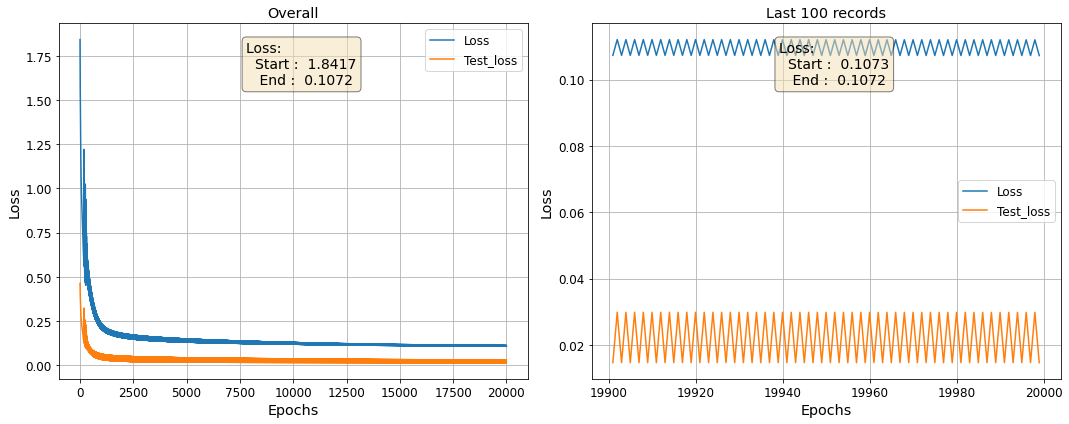

In [ ]:
loss_df = pd.DataFrame(loss_hist)

fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 100

ax = axes[0]

loss_df.plot(x = 'epoch', y = ['Loss','Test_loss'], ax = ax)
loss = loss_df['Loss'].values

# little beautification
txtstr = "Loss: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[0],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title('Overall')
ax.grid();

ax = axes[1]

loss_df[-l_range:].plot(x = 'epoch', y = ['Loss','Test_loss'], ax = ax)

# little beautification
txtstr = "Loss: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[-l_range],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title('Last {} records'.format(l_range))
ax.grid();
plt.tight_layout()